In [5]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#https://en.wikipedia.org/wiki/Vanishing_point

In [44]:
image = cv2.imread('pune-shirdi-highway-1024x576.jpeg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

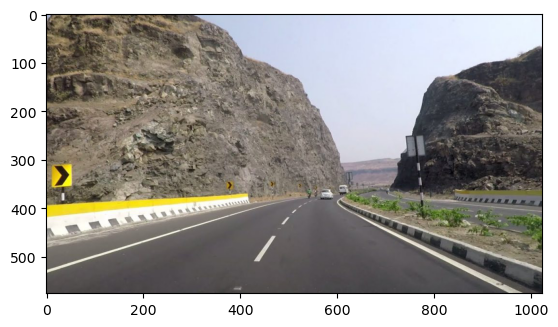

In [45]:
plt.imshow(image)

In [46]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [47]:
blurGray = cv2.GaussianBlur(gray, (5, 5), 1)
# Generating Edge image
edgeGray = cv2.Canny(blurGray, 40, 255)

# Finding Lines in the image
lines = cv2.HoughLinesP(edgeGray, 1, np.pi / 180, 50, 10, 15)
lines.shape

(32, 1, 4)

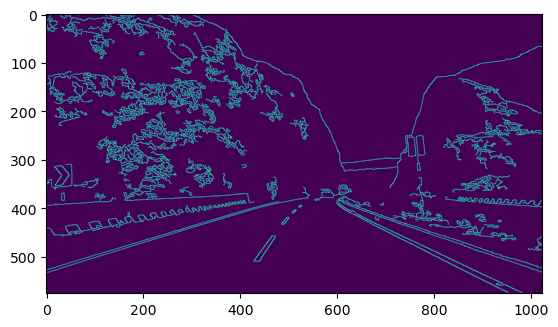

In [48]:
plt.imshow(edgeGray)

In [49]:
_image = image.copy()
for Line in np.squeeze(lines):
            cv2.line(_image, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)

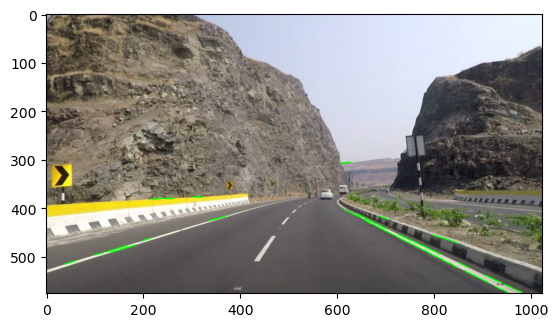

In [50]:
plt.imshow(_image)

In [51]:
def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1, x2, y2]] = Line

        # Calculating equation of the line: y = mx + c
        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2
        # theta will contain values between -90 -> +90. 
        theta = math.degrees(math.atan(m))

        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, m, c, l])

    
    # Removing extra lines 
    # (we might get many lines, so we are going to take only longest 15 lines 
    # for further computation because more than this number of lines will only 
    # contribute towards slowing down of our algo.)
    if len(FinalLines) > 15:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:15]
    
    return FinalLines

In [52]:
REJECT_DEGREE_TH = 4.0

In [53]:
lines = FilterLines(lines)

In [54]:
np.asarray(lines).shape

(15, 7)

In [55]:
def GetVanishingPoint(Lines):
    # We will apply RANSAC inspired algorithm for this. We will take combination 
    # of 2 lines one by one, find their intersection point, and calculate the 
    # total error(loss) of that point. Error of the point means root of sum of 
    # squares of distance of that point from each line.
    VanishingPoint = None
    MinError = 100000000000

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)

                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

In [56]:
vanishingPoint = GetVanishingPoint(lines)

In [58]:
_=cv2.circle(_image, (int(vanishingPoint[0]), int(vanishingPoint[1])), 10, (0, 0, 255), -1)


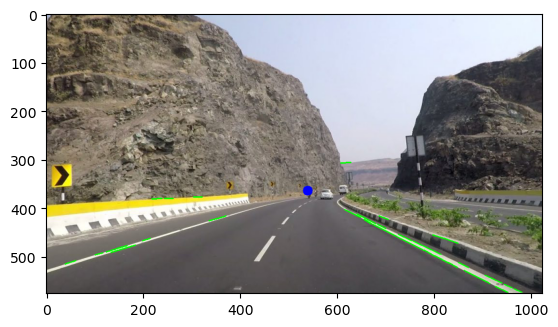

In [59]:
plt.imshow(_image)